<a href="https://colab.research.google.com/github/003Palkush/Zeotap/blob/main/Palkush_Dave_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Dependencies and performing basic functionalities

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Calculate customer lifetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
current_date = pd.Timestamp('2025-01-28')
customers['CustomerLifetime'] = (current_date - customers['SignupDate']).dt.days

# Aggregate transaction data
transaction_features = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Quantity': 'sum',
    'TotalValue': ['sum', 'mean']
})
transaction_features.columns = ['TransactionCount', 'TotalQuantity', 'TotalSpend', 'AvgOrderValue']

# Merge customer and transaction data
customer_data = customers.merge(transaction_features, left_on='CustomerID', right_index=True, how='left')
customer_data = customer_data.fillna(0)

# Select features for clustering
cluster_features = ['CustomerLifetime', 'TransactionCount', 'TotalQuantity', 'TotalSpend', 'AvgOrderValue']

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[cluster_features])


Determine Optimal Number of Clusters

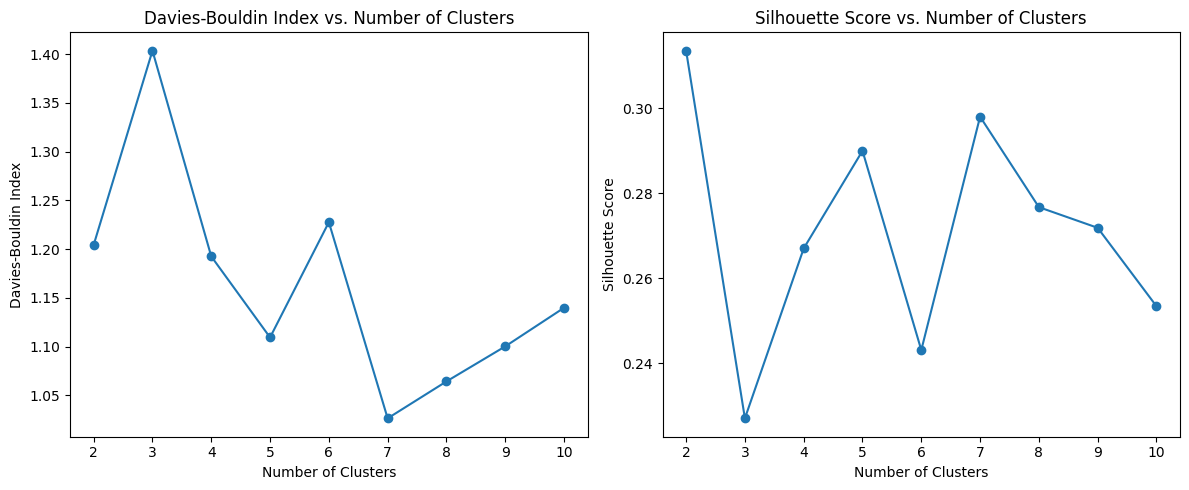

In [6]:
def evaluate_clusters(X, max_clusters=10):
    metrics = []
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        metrics.append({
            'Clusters': k,
            'DBI': davies_bouldin_score(X, labels),
            'Silhouette': silhouette_score(X, labels)
        })
    return pd.DataFrame(metrics)

cluster_metrics = evaluate_clusters(scaled_features)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_metrics.Clusters, cluster_metrics.DBI, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(cluster_metrics.Clusters, cluster_metrics.Silhouette, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

plt.tight_layout()
plt.show()


DBSCAN Results:
Davies-Bouldin Index: 1.3279
Silhouette Score: 0.3730

GMM Results:
Davies-Bouldin Index: 0.7491
Silhouette Score: 0.5088


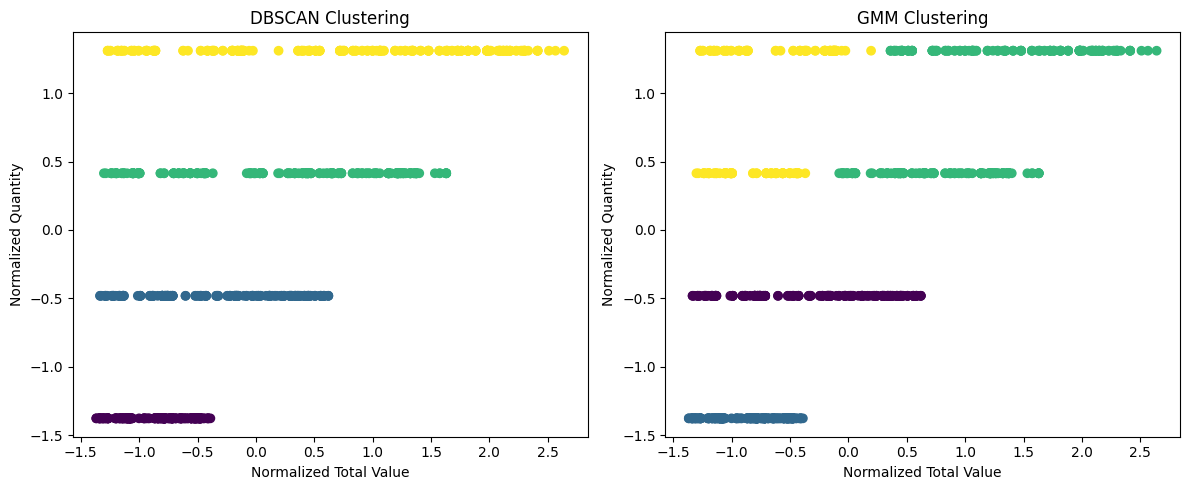

In [10]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

# Load and preprocess data
merged_data = pd.merge(transactions, customers, on='CustomerID')
features = merged_data[['TotalValue', 'Quantity']]

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Gaussian Mixture Model (GMM) Clustering
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(scaled_features)

# Calculate metrics
dbscan_db_index = davies_bouldin_score(scaled_features, dbscan_labels)
dbscan_silhouette = silhouette_score(scaled_features, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
gmm_db_index = davies_bouldin_score(scaled_features, gmm_labels)
gmm_silhouette = silhouette_score(scaled_features, gmm_labels)

# Print results
print("DBSCAN Results:")
print(f"Davies-Bouldin Index: {dbscan_db_index:.4f}")
print(f"Silhouette Score: {dbscan_silhouette:.4f}" if dbscan_silhouette else "Silhouette Score: N/A")

print("\nGMM Results:")
print(f"Davies-Bouldin Index: {gmm_db_index:.4f}")
print(f"Silhouette Score: {gmm_silhouette:.4f}")

# Visualize clusters
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Normalized Total Value')
plt.ylabel('Normalized Quantity')

plt.subplot(122)
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('Normalized Total Value')
plt.ylabel('Normalized Quantity')

plt.tight_layout()
plt.show()


Perform K-means Clustering

In [8]:
optimal_k = 4  # Chosen based on the elbow method and silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
silhouette = silhouette_score(scaled_features, customer_data['Cluster'])

print(f"Number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")


Number of clusters: 4
Davies-Bouldin Index: 1.1926
Silhouette Score: 0.2670


Explained Variance by PCA Components: [0.64703577 0.33641501]
Davies-Bouldin Index: 0.7426388513055799
Silhouette Score: 0.45894552144911005


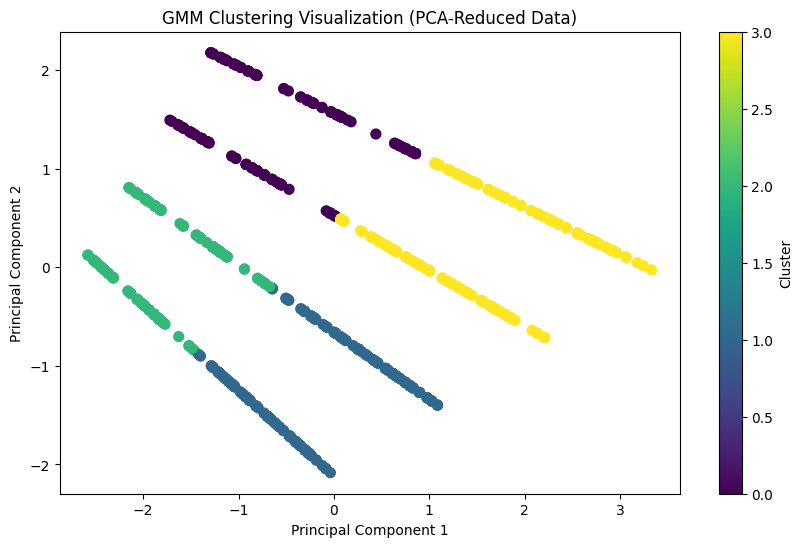

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

# Load datasets
transactions = pd.read_csv('Transactions.csv')
customers = pd.read_csv('Customers.csv')

# Merge datasets on CustomerID
merged_data = pd.merge(transactions, customers, on='CustomerID')

# Feature selection
features = merged_data[['Quantity', 'TotalValue', 'Price']]

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Display explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by PCA Components:", explained_variance)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(pca_features)

# Add cluster labels to merged data
merged_data['Cluster'] = gmm_labels

# Calculate clustering metrics
db_index = davies_bouldin_score(pca_features, gmm_labels)
silhouette_avg = silhouette_score(pca_features, gmm_labels)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title('GMM Clustering Visualization (PCA-Reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [16]:
cluster_summary = merged_data.groupby('Cluster').agg({
    'Quantity': ['mean', 'sum'],
    'TotalValue': ['mean', 'sum'],
    'Price': ['mean', 'sum'],
    'CustomerID': 'count'
}).reset_index()

cluster_summary.columns = ['Cluster',
                           'Avg_Quantity', 'Total_Quantity',
                           'Avg_TotalValue', 'Total_TotalValue',
                           'Avg_Price', 'Total_Price',
                           'Customer_Count']

print("\nCluster Summary Table:")
print(cluster_summary)


Cluster Summary Table:
   Cluster  Avg_Quantity  Total_Quantity  Avg_TotalValue  Total_TotalValue  \
0        0      3.538462             736      432.351827          89929.18   
1        1      1.489726             435      560.261438         163596.34   
2        2      1.533679             296      187.302746          36149.43   
3        3      3.485342            1070     1303.975928         400320.61   

    Avg_Price  Total_Price  Customer_Count  
0  120.668702     25099.09             208  
1  373.756507    109136.90             292  
2  121.642487     23477.00             193  
3  374.075179    114841.08             307  


<ipython-input-17-92208af7ad7f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x='Cluster', y='Total_TotalValue', palette='viridis')


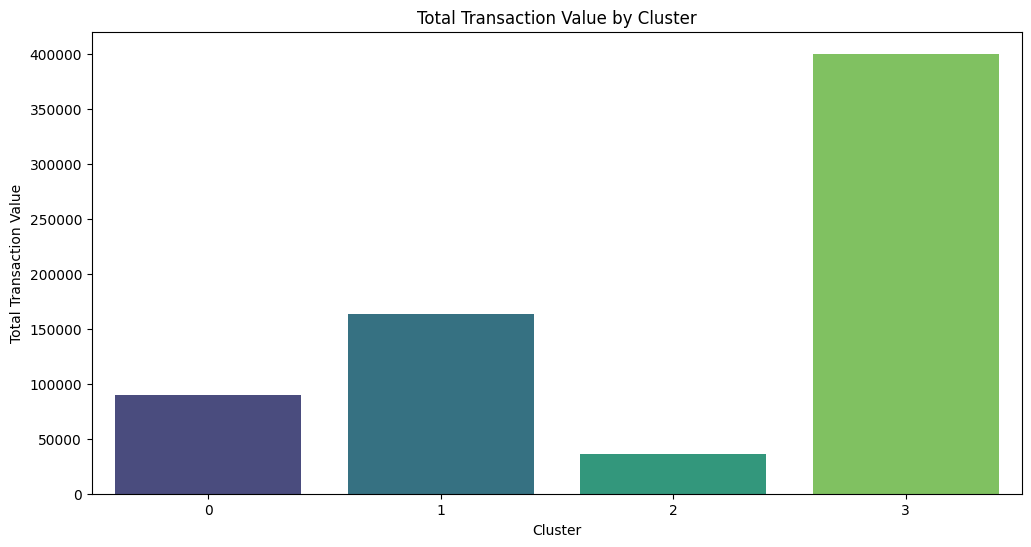

<ipython-input-17-92208af7ad7f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x='Cluster', y='Total_Quantity', palette='viridis')


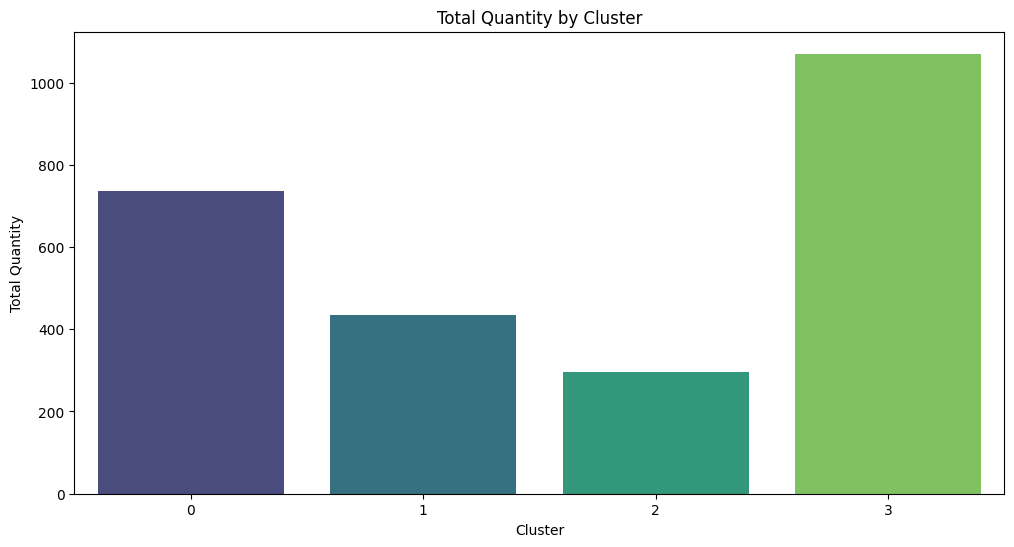

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_summary, x='Cluster', y='Total_TotalValue', palette='viridis')
plt.title('Total Transaction Value by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Transaction Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_summary, x='Cluster', y='Total_Quantity', palette='viridis')
plt.title('Total Quantity by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Quantity')
plt.show()

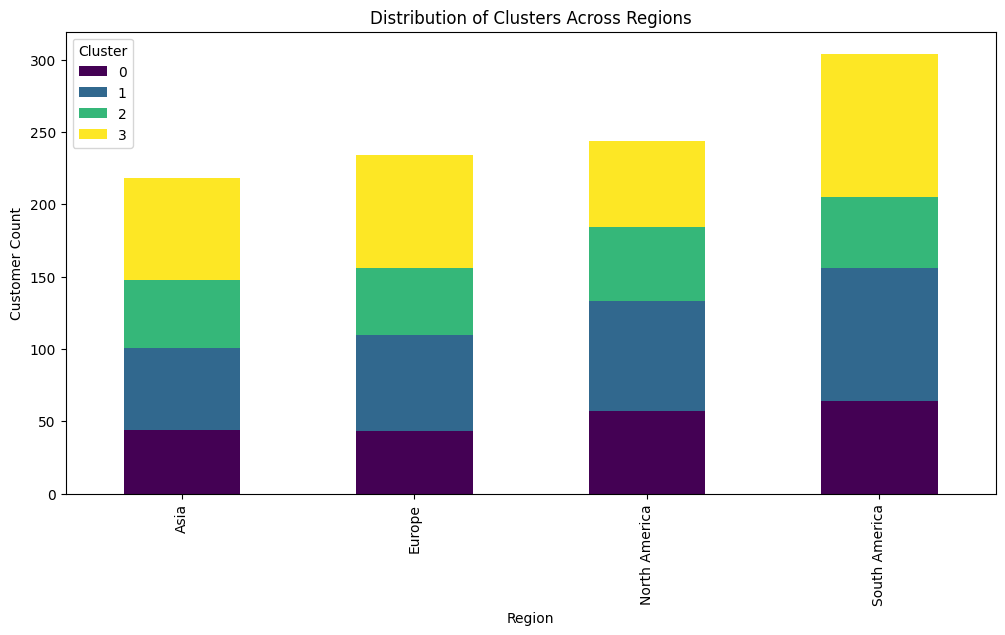

In [18]:
region_cluster_dist = merged_data.groupby(['Region', 'Cluster']).size().unstack(fill_value=0)
region_cluster_dist.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Distribution of Clusters Across Regions')
plt.xlabel('Region')
plt.ylabel('Customer Count')
plt.legend(title='Cluster')
plt.show()